beginning

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
# import seaborn as sns

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import forceatlas2_layout, circular_layout
from datashader.bundling import connect_edges, hammer_bundle

import networkx as nx
from networkx.algorithms import bipartite


In [2]:
# import label and edge

label_dense = pd.read_pickle("weibo/labels_dense.pkl")
label_sparse = pd.read_pickle("weibo/labels_sparse.pkl")

edge_dense = pd.read_pickle("./weibo/edges_dense.pkl")
edge_sparse = pd.read_pickle("./weibo/edges_sparse.pkl")

def export_graph(df_edge, title):
    g = nx.DiGraph()
    if df_edge.shape[1] == 2:
        g.add_edges_from(df_edge[['u','v']].astype(str).values)
    else:
        g.add_weighted_edges_from(df_edge[['u','v','JI']].values)
    nx.write_gml(g,title)

# export_graph(label_dense,'results/graph_viz/label_dense_150.gml')
# export_graph(label_sparse,'results/graph_viz/label_sparse.gml')
# export_graph(edge_dense,'results/graph_viz/edge_dense.gml')
# export_graph(edge_sparse,'results/graph_viz/edge_sparse.gml')

In [3]:
#import instance

XY = np.load('./weibo/dense_instance.npz')['arr_0']
Y = XY[:,:,-3]
X = XY[:,:,:-3]

def export_graph_instance(Y, title):
    g = nx.DiGraph()
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if Y[i,j] > 0:
                g.add_edge(str(i),str(j+500),weight=Y[i,j])
    nx.write_gml(g,title)

print(Y.shape)
# export_graph_instance(Y, 'graph_viz/instance.gml')

(500, 500)


In [4]:
def extract_from_df(df, name_df = "label") : 
    """
    -   input : df with columns |u|v|JI| if (name_df == "label") or |u|v| if (name_df == "edges")
    -   output : nodes df and edges df compatible with datashader"""

    nodes_list = df.groupby('u').count().index.union(df.groupby('v').count().index).tolist()
    influencers = df.groupby('u').count().index.tolist()
    targets = df.groupby('v').count().index.tolist()
    def type(u) : 
        if u in influencers : 
            if u in targets : return 'b'
            else : return 'i'
        else : return 't' 
    
    nodes = pd.DataFrame({'name' : nodes_list, 'type' : [type(u) for u in nodes_list]})
    nodes.index = nodes.name
    nodes.type = nodes.type.astype('category')
    
    if name_df == "label" : edges = df[['u', 'v', 'JI']].rename(columns={'u' : 'source', 'v' : 'target', 'JI' : 'weight'})
    else : edges = df[['u', 'v']].rename(columns={'u' : 'source', 'v' : 'target'})

    return nodes, edges 
    
nodes, edges = extract_from_df(label_sparse, name_df = "edge")
nodes.groupby('type').count()

,name
type,
b,468
i,2688
t,35942


Bundled sparse labels

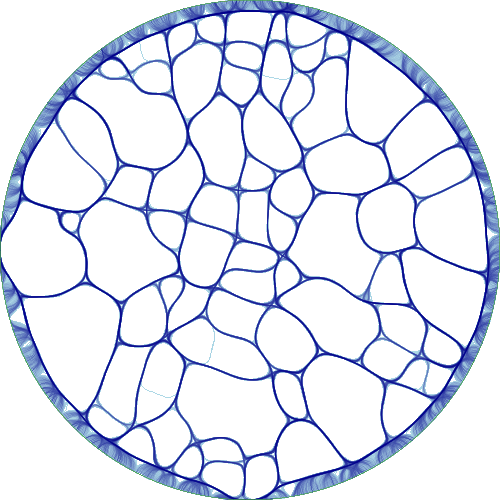

In [5]:
cvsopts = dict(plot_height=500, plot_width=500)

def graphplot(nodes, edges, name="", cat=None, bundling = True):
    
    # nodes = forceatlas2_layout(nodes, edges, iterations=5, linlog=True, k=1/(len(nodes))**5)
    nodes = circular_layout(nodes, edges)
    
    canvas = ds.Canvas(x_range= (nodes.x.min(), nodes.x.max()), y_range=(nodes.y.min(), nodes.y.max()), **cvsopts)
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    nodes_img = tf.shade(agg, cmap='Pastel1')
    
    edges = hammer_bundle(nodes, edges) if bundling else connect_edges(nodes, edges)
    edges_img = tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    return tf.stack(edges_img, nodes_img, how="over", name=name)

tf.Images(graphplot(nodes, edges, "Bundled sparse labels", cat='type', bundling=True))

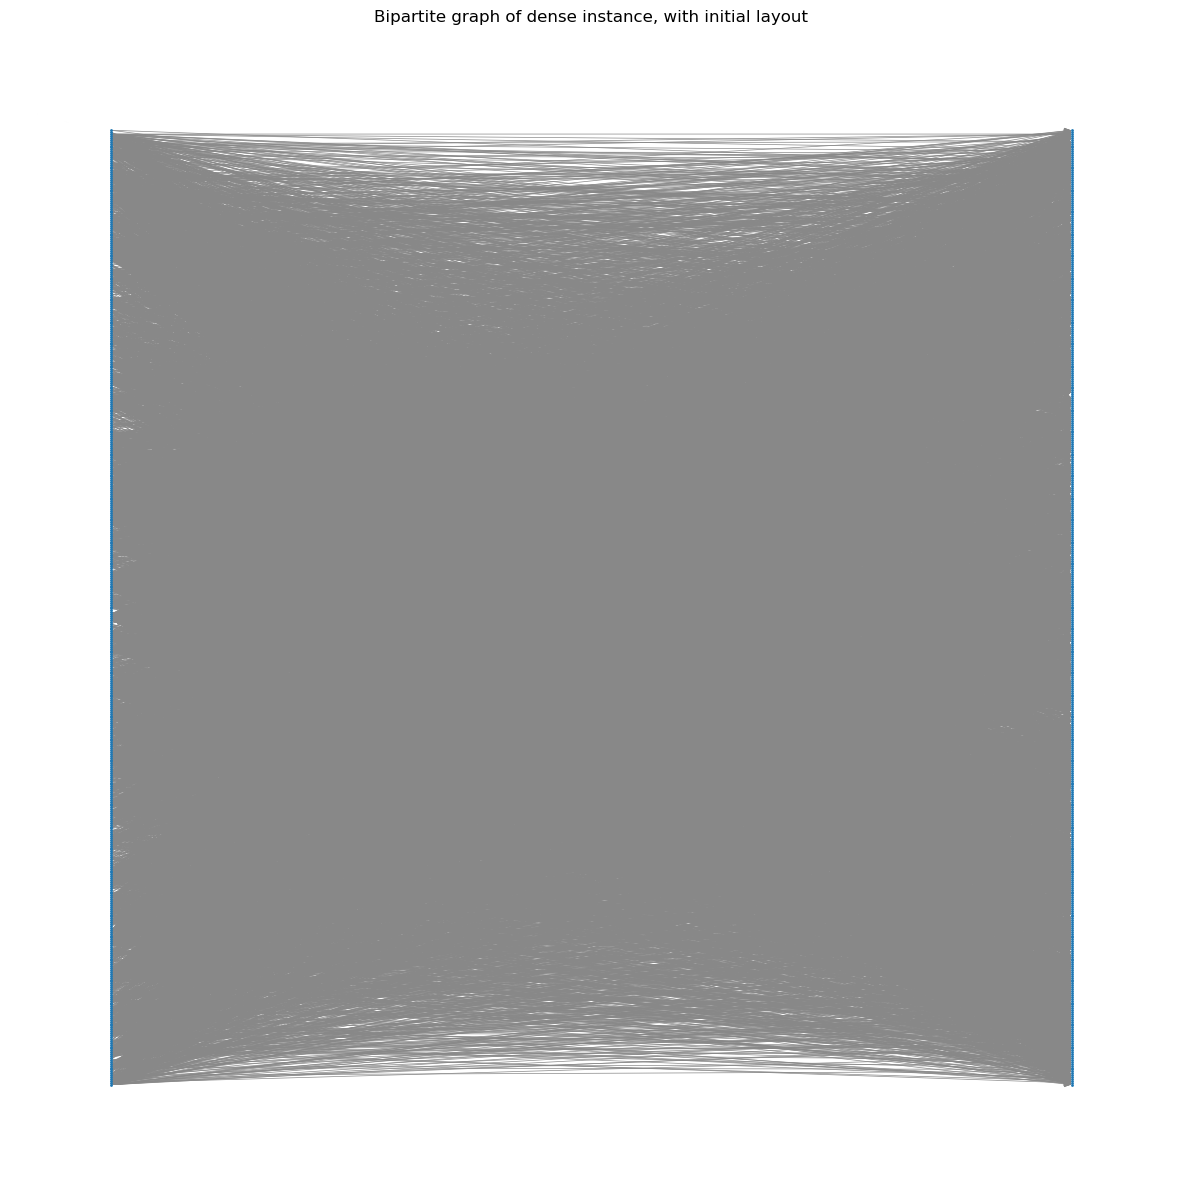

In [6]:
""" bipartite graph in networkx """
U = list(range(Y.shape[0]))
V = list(range(Y.shape[0], Y.shape[0] + Y.shape[1]))
g_instance = nx.DiGraph()
g_instance.add_nodes_from(U, bipartite=0)
g_instance.add_nodes_from(V, bipartite=1)
for u in range(Y.shape[0]) : 
    for vx in range(Y.shape[1]) : 
        if Y[u,vx] > 0 :
            g_instance.add_edge(u, V[vx]) #, weight = Y[u,vx])

pos = nx.bipartite_layout(g_instance, U)
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(g_instance, pos=pos,ax=ax, node_size=1, edge_color='#888888', width=0.5)
ax.set_title("Bipartite graph of dense instance, with initial layout")
plt.show()


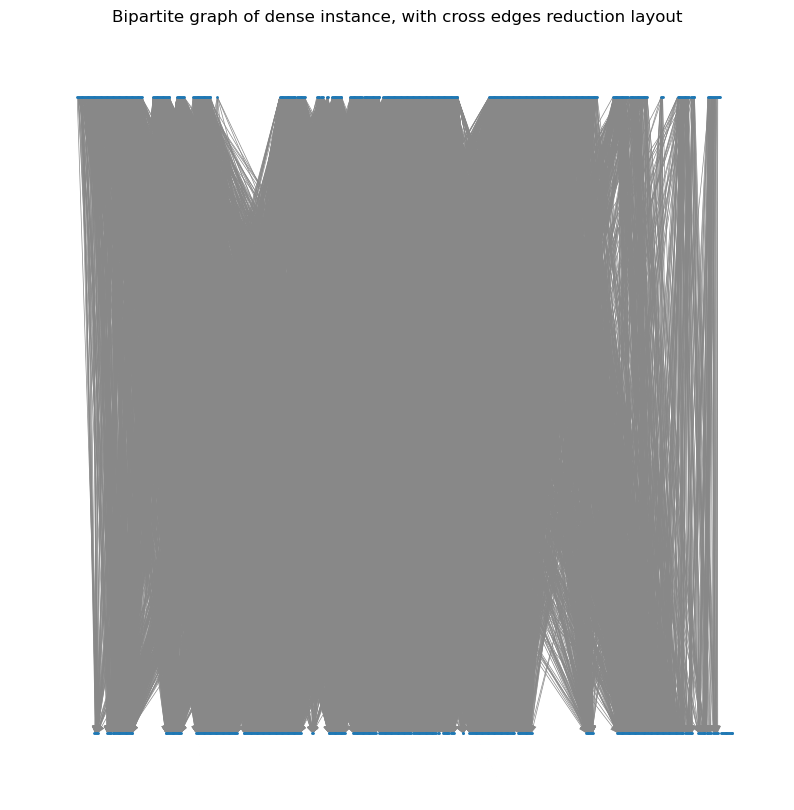

In [7]:
""" cross edges reduction layout is only available for igraph"""
import igraph 
g_instance_igraph = igraph.Graph.Bipartite([0] * 500 + [1] * 500,g_instance.edges())
g_instance_igraph.simplify()

layout_bi = g_instance_igraph.layout_bipartite(hgap = 1, vgap = 1, maxiter = 100)
layout_bi_df = pd.DataFrame(layout_bi.coords, columns=['x', 'y'])
layout_bi_df.index.name = 'id'
layout_bi_nx = dict({i : np.array([layout_bi_df.loc[i, 'x'], layout_bi_df.loc[i, 'y']]) for i in range(layout_bi_df.shape[0])})

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(g_instance, pos=layout_bi_nx, ax = ax, node_size=1, edge_color='#888888', width=0.5)
ax.set_title("Bipartite graph of dense instance, with cross edges reduction layout")
plt.show()


"Bipartite layout with cross edge redution, Bundled"

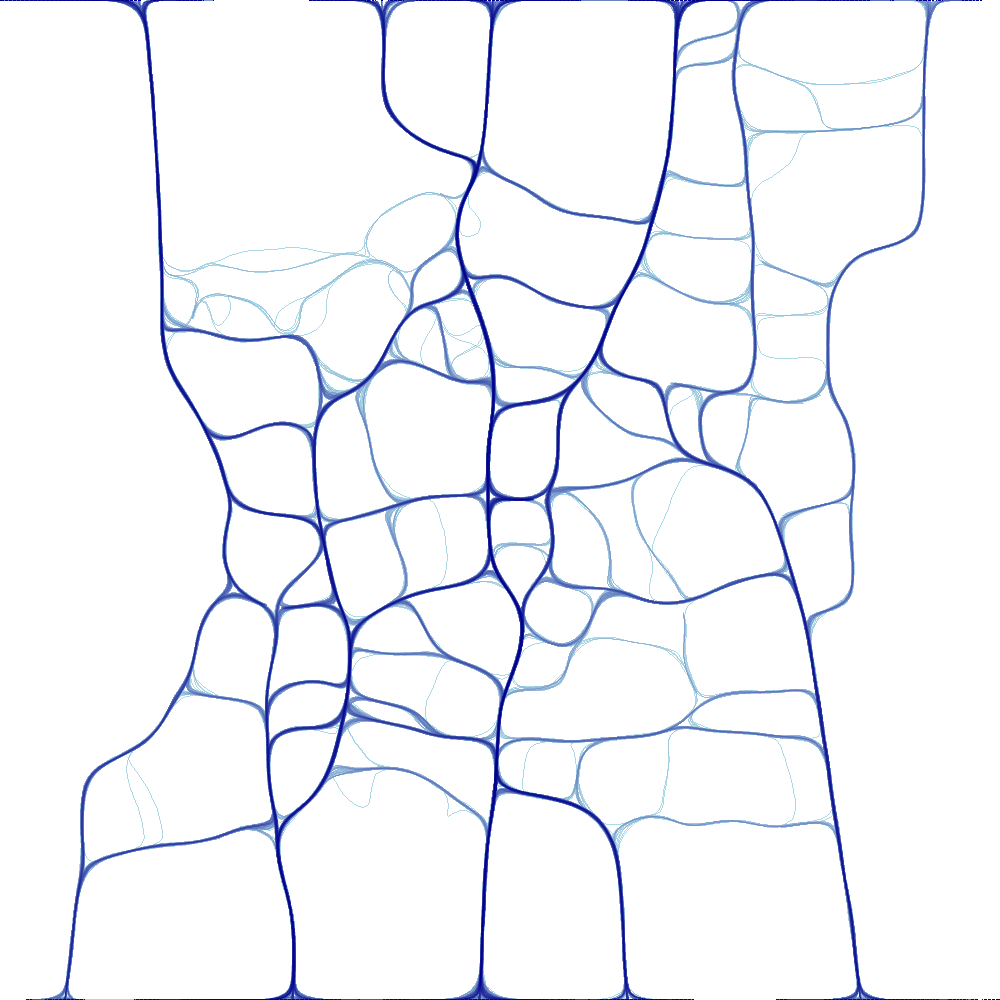

In [8]:
def apply_bundling_to_nx(g, pos, initial_bandwidth=0.1, decay=0.5, name="") : 
    """ pos is dict({node : np.array([x,y])}) """
    data = [[node]+pos[node].tolist() for node in g.nodes]
    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)
    edges = pd.DataFrame(list(g.edges), columns=['source', 'target'])

    cvsopts = dict(plot_height=1000, plot_width=1000)

    canvas = ds.Canvas(x_range= (nodes.x.min(), nodes.x.max()), y_range=(nodes.y.min(), nodes.y.max()), **cvsopts)
    agg=canvas.points(nodes,'x','y')
    nodes_img = tf.shade(agg)
        
    edges = hammer_bundle(nodes, edges, initial_bandwidth=initial_bandwidth, decay=decay)
    edges_img = tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name="")
    stack = tf.stack(edges_img, nodes_img, how="over", name=name)

    return tf.Images(stack)

apply_bundling_to_nx(g_instance, layout_bi_nx, name="Bipartite layout with cross edge redution, Bundled")

In [9]:

def circular_bi(pos, r1, r2) : 
    """projects bipartite layout where u on top and v on bottom to two circles with different radius""" 
    pos_circ = {}
    xmin = min([pos[k][0] for k in pos.keys()])
    xmax = max([pos[k][0] for k in pos.keys()])
    ymin = min([pos[k][1] for k in pos.keys()])
    ymax = max([pos[k][1] for k in pos.keys()])
    for k in pos.keys() :
        r = r1 if pos[k][1] == ymin else r2
        pos_circ[k] = np.array([r * np.cos(2*np.pi * (xmax - pos[k][0]) / (xmax - xmin)), r * np.sin( 2 * np.pi * (xmax - pos[k][0]) / (xmax - xmin))])
    return pos_circ

circular_bi_proj = circular_bi(layout_bi_nx, 2.0, 1.0)
# nx.draw(g_instance, pos=circular_bi_proj, node_size=1, edge_color='#888888', width=0.5, alpha = 0.1)



In [10]:
#convert to matplotlib plots 
def pos_nx_to_df(pos) : 
    data = [[node]+pos[node].tolist() for node in pos.keys()]
    nodes = pd.DataFrame(data, columns=['id', 'x', 'y'])
    nodes.set_index('id', inplace=True)
    return nodes

def get_bundle_curves(g, pos, initial_bandwidth=0.1, decay=0.5, name="") : 

    edges = pd.DataFrame(list(g.edges), columns=['source', 'target'])
    edges = hammer_bundle(pos, edges, initial_bandwidth=initial_bandwidth, decay=decay)
    return edges

bundle_curves = get_bundle_curves(g_instance, pos_nx_to_df(circular_bi_proj), initial_bandwidth=0.3, decay=0.6, name = "Instance graph")
splits = np.isnan(bundle_curves.to_numpy())[:,0].nonzero()[0]
# bundle_curves.plot(x='x', y='y', figsize=(10,10))


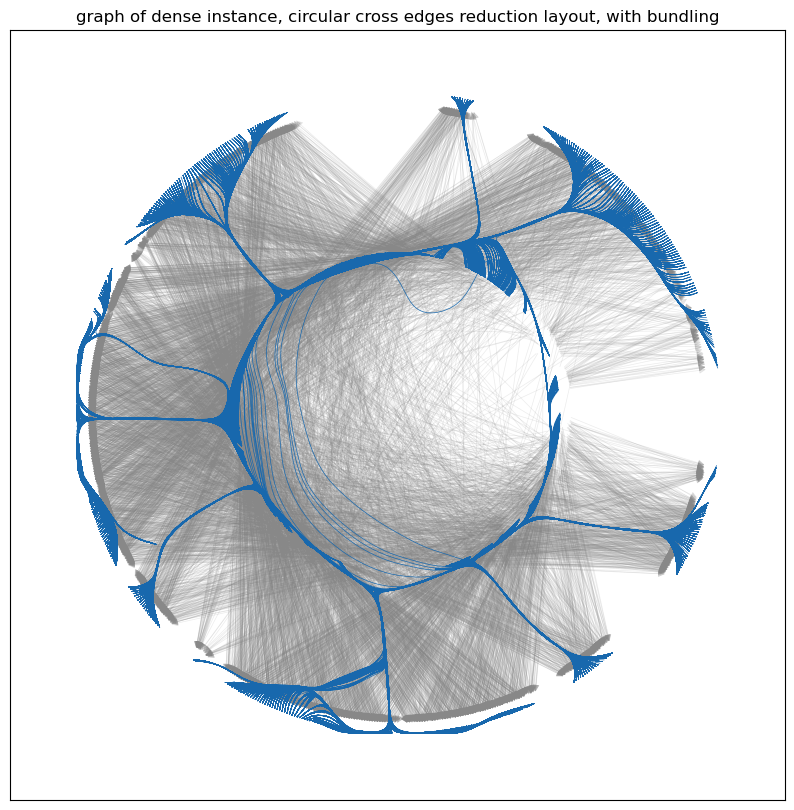

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx_edges(g_instance, pos=circular_bi_proj, alpha=0.1618, ax=ax, edge_color='#888888', width=0.5)
ax.plot(bundle_curves.x, bundle_curves.y, '#1868AD', zorder=1, linewidth=0.5, )
ax.set_title("graph of dense instance, circular cross edges reduction layout, with bundling")
plt.show()

In [13]:
import torch
### IM greedy algorithm
def set_func(S, P):
    s = torch.zeros(P.shape[0])
    s[S] = 1
    return float(torch.sum(1 - torch.prod(1 - (s*P.T).T, axis = 0)))
def marginal_vec(S, P):
    s = torch.zeros(P.shape[0])
    s[S] = torch.ones(len(S))
    sc = torch.ones_like(s) - s
    return sc * torch.mv(P, torch.prod(1 - (s*P.T).T, axis = 0))
def greedy2(K, P):
    S = []
    for i in range(K):
        g = marginal_vec(S, P)
        s = int(torch.argmax(g))
        if s not in S: 
            S += [s]
    return S
    
seeds_20 = greedy2(20, torch.from_numpy(Y))

In [14]:
#splits_greedy gets the index of the edges where the influencer is in the seed set
#is_greedy gets 1 if the point in bundle_edges is in an edge having an influencer in the seed set

splits_greedy = []
for i, edge in enumerate(g_instance.edges()) :
    if edge[0] in seeds_20 : 
        splits_greedy.append(i)
        
is_greedy = []
for i in range(len(splits_greedy)):
    is_greedy += list(range(splits[splits_greedy[i]], splits[splits_greedy[i]+1]))


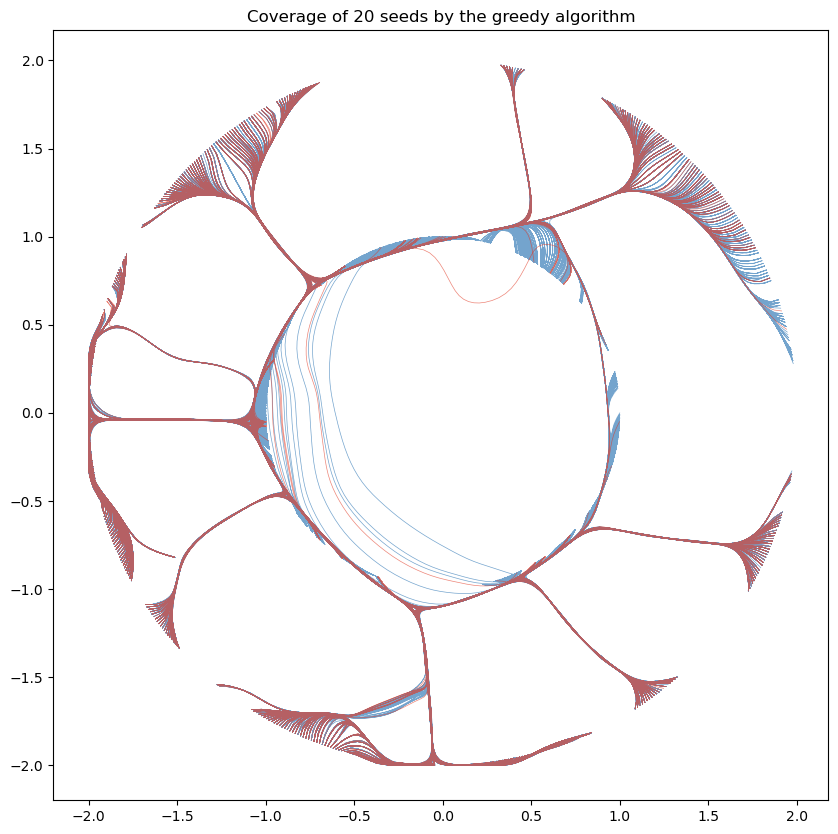

In [22]:
bundle_curves_greedy = bundle_curves[bundle_curves.index.isin(is_greedy)]
bundle_curves_other = bundle_curves[~bundle_curves.index.isin(is_greedy)]

efig, ax = plt.subplots(figsize=(10,10))
# nx.draw_networkx_edges(g_instance, pos=circular_bi_proj, alpha=0.01, ax=ax, edge_color='#888888', width=0.5)

ax.plot(bundle_curves_other.x, bundle_curves_other.y, '#1868AD', zorder=1, linewidth=0.5, alpha = 0.6)
ax.plot(bundle_curves_greedy.x, bundle_curves_greedy.y, '#E1341E', zorder=1, linewidth=0.5, alpha = 0.6)
ax.set_title("Coverage of 20 seeds by the greedy algorithm")
plt.show()